Process for creating debris cover masks for RGI v7.0 outlines.

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import pandas as pd
from datetime import timedelta
from datetime import datetime

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_debris = os.path.join(folder_HMA, 'Datasets', 'debris cover')
folder_rgi = os.path.join(folder_HMA, 'Datasets', 'RGI')

In [3]:
# open csvs that allow us to link rgiids between v6 and v7
link_13 = pd.read_csv(os.path.join(folder_rgi, 'links', 'RGI2000-v7.0-G-13_central_asia-rgi6_links.csv'))
link_14 = pd.read_csv(os.path.join(folder_rgi, 'links', 'RGI2000-v7.0-G-14_south_asia_west-rgi6_links.csv'))
link_15 = pd.read_csv(os.path.join(folder_rgi, 'links', 'RGI2000-v7.0-G-15_south_asia_east-rgi6_links.csv'))
# link_15.head()

In [4]:
##### open RGI v7 and herreid2020 data

# herreid debris cover, herreid glacier extents, rgi v7, and then fix 3d geometry
h_dc_15 = gpd.read_file(os.path.join(folder_debris, 'Herreid2020', '15SouthAsiaEast', '15SouthAsiaEast_minGl1km2_debrisCover.shp')).to_crs("ESRI:102025")
h_g_15 = gpd.read_file(os.path.join(folder_debris, 'Herreid2020', '15SouthAsiaEast', '15SouthAsiaEast_minGl1km2.shp')).to_crs("ESRI:102025")
rgi_15 = gpd.read_file(os.path.join(folder_rgi, 'v7', 'G', 'RGI2000-v7.0-G-15_south_asia_east', 'RGI2000-v7.0-G-15_south_asia_east.shp')).to_crs("ESRI:102025")
rgi_15['geometry'] = gpd.GeoSeries.from_wkb(rgi_15.to_wkb(output_dimension=2).geometry)

h_dc_13 = gpd.read_file(os.path.join(folder_debris, 'Herreid2020', '13CentralAsia', '13CentralAsia_minGl1km2_debrisCover.shp')).to_crs("ESRI:102025")
h_g_13 = gpd.read_file(os.path.join(folder_debris, 'Herreid2020', '13CentralAsia', '13CentralAsia_minGl1km2.shp')).to_crs("ESRI:102025")
rgi_13 = gpd.read_file(os.path.join(folder_rgi, 'v7', 'G', 'RGI2000-v7.0-G-13_central_asia', 'RGI2000-v7.0-G-15_central_asia.shp')).to_crs("ESRI:102025")
rgi_13['geometry'] = gpd.GeoSeries.from_wkb(rgi_13.to_wkb(output_dimension=2).geometry)

h_dc_14 = gpd.read_file(os.path.join(folder_debris, 'Herreid2020', '14SouthAsiaWest', '14SouthAsiaWest_minGl1km2_debrisCover.shp')).to_crs("ESRI:102025")
h_g_14 = gpd.read_file(os.path.join(folder_debris, 'Herreid2020', '14SouthAsiaWest', '14SouthAsiaWest_minGl1km2.shp')).to_crs("ESRI:102025")
rgi_14 = gpd.read_file(os.path.join(folder_rgi, 'v7', 'G', 'RGI2000-v7.0-G-14_south_asia_west', 'RGI2000-v7.0-G-15_south_asia_west.shp')).to_crs("ESRI:102025")
rgi_14['geometry'] = gpd.GeoSeries.from_wkb(rgi_14.to_wkb(output_dimension=2).geometry)

### rename the rgiids in herreid datasets (they say 50 instead of 60)
h_g_13 = h_g_13.rename(columns={"RGIId": "RGIId_old"})
h_g_13['RGIId_6'] = [ f"RGI60-{r[-8:]}" for r in h_g_15['RGIId_old']]

h_g_14 = h_g_14.rename(columns={"RGIId": "RGIId_old"})
h_g_14['RGIId_6'] = [ f"RGI60-{r[-8:]}" for r in h_g_15['RGIId_old']]

h_g_15 = h_g_15.rename(columns={"RGIId": "RGIId_old"})
h_g_15['rgi6_id'] = [ f"RGI60-{r[-8:]}" for r in h_g_15['RGIId_old']]

# add rgi7_id to herreid data                                   
h_g_13 = h_g_13.merge(link_15[['rgi6_id','rgi7_id']], how='left', left_on='rgi6_id', right_on='rgi6_id')
h_g_14 = h_g_14.merge(link_15[['rgi6_id','rgi7_id']], how='left', left_on='rgi6_id', right_on='rgi6_id')
h_g_15 = h_g_15.merge(link_15[['rgi6_id','rgi7_id']], how='left', left_on='rgi6_id', right_on='rgi6_id')

In [ ]:
# concat everything into single dfs
h_g_all = gpd.GeoDataFrame(pd.concat([h_g_13,h_g_14,h_g_15]))
h_dc_all = 0
rgi_all = 0


In [61]:
### lets think about how we want to do this.
# the debris cover extents by herreid do not cover the entire rgi v7 area
# so we need to infill the un-classfied area with either debris or non-debris

all_results = []

# filter out glacier smaller than 1km2
rgi_15_1km = rgi_15[rgi_15['area_km2']>=1]
print(rgi_15_1km.shape)

# # for each glacier outline in rgi v7
c=0
for idx,row in rgi_15_1km.iterrows():
    c+=1
    # if c>1: continue
    
    # get rgi id
    rgi_id_7 = row['rgi_id']
    # if row['area_km2']<20: continue
    # if rgi_id_7 != "RGI2000-v7.0-G-15-06758": continue
    
    g = row['geometry']
    
    # get all the products from herreid that intercept with it
    h_g_intersect = h_g_15[h_g_15['geometry'].intersects(row['geometry'])]
    h_dc_intersect = h_dc_15[h_dc_15['geometry'].intersects(row['geometry'])]
    
    # if there is no debris identified, then we don't care about this glacier and we can skip
    if len(h_dc_intersect)==0: continue
    
    # otherwise, merge the geometries
    h_g_merged = shapely.union_all(h_g_intersect.geometry).buffer(0)
    h_dc_merged = shapely.union_all(h_dc_intersect.geometry.buffer(30)) # buffer by 30 to get rid of pixel edges
    
    # then clip to the rgi extent
    h_g_inrgi = shapely.intersection_all([h_g_merged, row['geometry']]).buffer(0)
    h_dc_inrgi = shapely.intersection_all([h_dc_merged, row['geometry']]).buffer(0)
    
    # get the areas that were within herreid glacier extent but not debris
    h_ndc_inrgi = h_g_inrgi.difference(h_dc_inrgi).buffer(-10)
    
    # lastly get the areas within rgi7 that were not considered by herreid
    no_id = row['geometry'].difference(h_g_inrgi).buffer(0)
    
    # for each polygon in no_id, if it touches dc and doesnt touch ndc (or vice versa) then it should be that one
    if no_id.is_empty:
        all_polys = []
    elif no_id.geom_type == 'Polygon':
        all_polys = [no_id]
    elif no_id.geom_type == 'MultiPolygon':
        all_polys = list(no_id.geoms)
    
    polys_dc = [h_dc_inrgi]
    polys_ndc = [h_ndc_inrgi]
    for p in all_polys:
        
        # check distance to dc
        distance_dc = p.distance(h_dc_inrgi)
        distance_ndc = p.distance(h_ndc_inrgi)
        
        # if equal distance, we will make it non debris covered
        if distance_dc==distance_ndc:
            polys_dc.append(p)
        elif distance_ndc<distance_dc:
            polys_ndc.append(p)
        else:
            polys_dc.append(p)
    
    # recombine everything together
    dc = shapely.union_all(polys_dc).buffer(0)
    ndc = shapely.union_all(polys_ndc).buffer(0)
    
    # buffer ndc by 100, to get rid of debris bordering ice
    ndc_buff = ndc.buffer(100)
    dc_final = dc.difference(ndc_buff).buffer(0)
    ### dc_final now holds the final debris cover area for this glacier
    
    # if there is no remaining debris cover left, skip
    if dc_final.area==0: continue
    
    # save the new data
    row_out = {"rgi_id":rgi_id_7, 'geometry':dc_final}
    all_results.append(row_out)
    
    # if len(all_results)>10:
    #     break
        
# format to gdf and save
out_path = os.path.join(folder_debris, "Final products", "test.shp")
gdf = gpd.GeoDataFrame(all_results, crs="ESRI:102025")
gdf.to_file(out_path)

(2894, 29)


(182187.63409366267, 725309.2007089576, -246548.8511536712, 179538.91829646175)

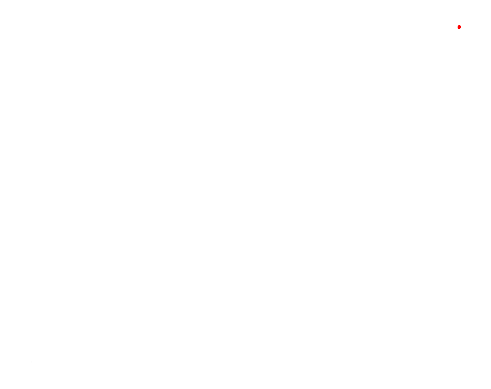

In [62]:
fig,axs = plt.subplots()
gpd.GeoSeries(dc_final).plot(ax=axs, color='black')
gpd.GeoSeries(g).exterior.plot(ax=axs, color='red')
axs.axis('off')

(-750261.5077112267,
 -743240.926312286,
 -217554.2930804408,
 -211204.48191440004)

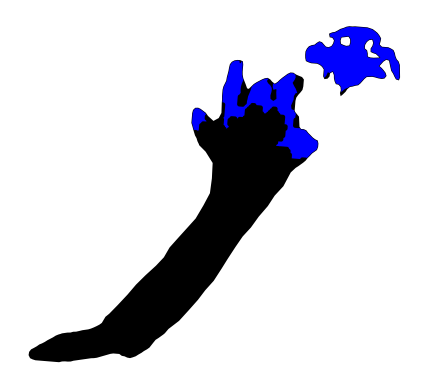

In [60]:
fig,axs = plt.subplots()
gpd.GeoSeries(h_g_merged).plot(ax=axs, color='black')
gpd.GeoSeries(h_ndc_inrgi.buffer(0)).plot(ax=axs, color='blue')
# gpd.GeoSeries(g).exterior.plot(ax=axs, color='red')
axs.axis('off')

In [ ]:
gdf